# Stock Price Prediction using PatchTST with Weighted Ensemble Learning

## Kapita Selekta - Kelompok 3

**Authors:**
- 2200018401 - Mohammad Farid Hendianto
- 2200018185 - Fidyah Rahman

---

## Abstract

This research implements a state-of-the-art stock price forecasting system using **PatchTST (Patch Time Series Transformer)** architecture combined with **Weighted Ensemble Learning**. The model incorporates Reversible Instance Normalization (RevIN) to handle distribution shift in financial time series data.

## Methodology

### 1. Model Architecture: PatchTST with RevIN

The core architecture consists of:
- **Reversible Instance Normalization (RevIN)**: Normalizes input sequences per-instance and denormalizes predictions, effectively handling non-stationary financial data.
- **Patch Embedding**: Segments time series into patches of length 8 with stride 4, capturing local temporal patterns.
- **Transformer Encoder**: 5-layer encoder with 8 attention heads and dimension 384.
- **Two-Layer Prediction Head**: Projects encoded representations to multi-horizon forecasts.

### 2. Ensemble Strategy

We employ a weighted ensemble of 7 independently trained models:
- Each model trained with different random seeds for diversity
- Weights computed as inverse of validation loss (better models contribute more)
- Final prediction: weighted average across all ensemble members

### 3. Loss Function

Custom multi-component loss function optimizing:
- Smooth L1 Loss (robust to outliers)
- MSE on t+1 prediction (primary evaluation target)
- MAPE-like percentage loss
- Directional accuracy penalty

### 4. Feature Engineering

12 technical indicators selected for predictive power:
- Price-based: Log returns, KAMA
- Momentum: RSI (7, 14), Stochastic, ROC, MACD
- Trend: ADX
- Volatility: ATR
- Volume: OBV
- Autoregressive: Lagged returns

---

## References

Kim, T., Kim, J., Tae, Y., Park, C., Choi, J.-H., & Choo, J. (2022). Reversible instance normalization for accurate time-series forecasting against distribution shift. *Proceedings of the International Conference on Learning Representations (ICLR)*. https://openreview.net/forum?id=cGDAkQo1C0p

Loshchilov, I., & Hutter, F. (2019). Decoupled weight decay regularization. *Proceedings of the International Conference on Learning Representations (ICLR)*.

Nie, Y., Nguyen, N. H., Sinthong, P., & Kalagnanam, J. (2023). A time series is worth 64 words: Long-term forecasting with transformers. *Proceedings of the International Conference on Learning Representations (ICLR)*. https://arxiv.org/abs/2211.14730

Nugent, C. (2018). *S&P 500 stock data* [Data set]. Kaggle. https://www.kaggle.com/datasets/camnugent/sandp500

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017). Attention is all you need. *Advances in Neural Information Processing Systems (NeurIPS)*, 30.

## Section 1: Environment Setup

Initialize computational environment, import libraries, and configure reproducibility settings.


In [74]:
import sys

# Install required packages
%pip install --upgrade pip -q
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121 -q
%pip install pandas pandas_ta matplotlib seaborn -q

# Core libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import random
import os
import warnings
warnings.filterwarnings('ignore')

# Reproducibility Configuration
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("=" * 60)
print("ENVIRONMENT CONFIGURATION")
print("=" * 60)
print(f"Device: {device}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Random Seed: {SEED}")
print(f"PyTorch Version: {torch.__version__}")
print("=" * 60)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ENVIRONMENT CONFIGURATION
Device: cuda
CUDA Available: True
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Random Seed: 42
PyTorch Version: 2.5.1+cu121


## Section 2: Feature Engineering

### Technical Indicator Selection

We construct a feature set of 12 technical indicators, categorized as follows:

| Category | Indicators | Purpose |
|----------|------------|---------|
| **Price-Based** | Log Returns, KAMA | Capture price momentum and adaptive trends |
| **Momentum** | RSI (7, 14), Stochastic, MACD, ROC | Identify overbought/oversold conditions |
| **Trend** | ADX | Measure trend strength |
| **Volatility** | ATR | Quantify market volatility |
| **Volume** | OBV | Track volume-price relationships |
| **Autoregressive** | Lagged Returns | Incorporate temporal dependencies |

**Note:** RevIN (Reversible Instance Normalization) handles input normalization internally, eliminating the need for external standardization.

In [75]:
# === CONFIGURATION PARAMETERS ===
DATA_PATH = 'dataset/sandp500/all_stocks_5yr.csv'
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/dataset/sandp500/all_stocks_5yr.csv'

# Model hyperparameters
TICKER = 'AAPL'              # Target stock ticker
LOOKBACK_WINDOW = 64         # Input sequence length (power of 2 for efficient patching)
FORECAST_HORIZON = 5         # Number of days to predict
PATCH_LEN = 8                # Patch length for PatchTST
STRIDE = 4                   # Stride between patches


def engineer_features(path: str, ticker: str) -> tuple:
    """
    Generate technical indicators for stock price prediction.
    
    Parameters
    ----------
    path : str
        Path to the CSV data file
    ticker : str
        Stock ticker symbol
        
    Returns
    -------
    tuple
        (DataFrame with features, list of feature column names)
    """
    print(f"[INFO] Processing data for {ticker}...")
    df_all = pd.read_csv(path)

    # Standardize column names
    df_all.rename(columns={
        'date': 'Date', 'open': 'Open', 'high': 'High',
        'low': 'Low', 'close': 'Close', 'volume': 'Volume', 'name': 'Name'
    }, inplace=True)

    # Filter for target ticker
    df = df_all[df_all['Name'] == ticker].copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # === TECHNICAL INDICATORS ===
    # Trend indicators
    df.ta.kama(length=10, append=True)           # Kaufman Adaptive Moving Average
    df.ta.adx(length=14, append=True)            # Average Directional Index
    
    # Momentum indicators
    df.ta.rsi(length=14, append=True)            # Relative Strength Index (standard)
    df.ta.rsi(length=7, append=True)             # RSI (fast, for short-term momentum)
    df.ta.macd(fast=12, slow=26, signal=9, append=True)  # MACD
    df.ta.stoch(k=14, d=3, append=True)          # Stochastic Oscillator
    df.ta.roc(length=5, append=True)             # Rate of Change
    
    # Volatility indicators
    df.ta.atr(length=14, append=True)            # Average True Range
    
    # Volume indicators
    df.ta.obv(append=True)                       # On-Balance Volume

    # Target variable: Log returns (percentage)
    df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1)) * 100
    
    # Autoregressive features
    df['Log_Ret_Lag1'] = df['Log_Ret'].shift(1)  # t-1 return
    df['Log_Ret_Lag2'] = df['Log_Ret'].shift(2)  # t-2 return

    # Remove rows with NaN values
    df.dropna(inplace=True)

    # Feature selection (12 features)
    cols_to_use = [
        'Log_Ret',          # Target variable (must be first)
        'KAMA_10_2_30',     # Adaptive moving average
        'RSI_14',           # Standard RSI
        'RSI_7',            # Fast RSI
        'ADX_14',           # Trend strength
        'ATRr_14',          # Volatility ratio
        'MACD_12_26_9',     # MACD line
        'MACDh_12_26_9',    # MACD histogram
        'OBV',              # Volume indicator
        'STOCHk_14_3_3',    # Stochastic %K
        'ROC_5',            # Rate of change
        'Log_Ret_Lag1',     # Lagged return
    ]

    # Filter to available columns
    final_cols = [c for c in cols_to_use if c in df.columns]
    print(f"[INFO] Generated {len(final_cols)} features")
    
    return df, final_cols


# Execute feature engineering
if os.path.exists(DATA_PATH):
    df, feature_cols = engineer_features(DATA_PATH, TICKER)
    print(f"[INFO] Selected Features ({len(feature_cols)}): {feature_cols}")
    print(f"[INFO] Dataset shape: {df.shape}")
    print(f"[INFO] Date range: {df['Date'].min()} to {df['Date'].max()}")
else:
    raise FileNotFoundError(f"Dataset not found at: {DATA_PATH}")

[INFO] Processing data for AAPL...
[INFO] Generated 12 features
[INFO] Selected Features (12): ['Log_Ret', 'KAMA_10_2_30', 'RSI_14', 'RSI_7', 'ADX_14', 'ATRr_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'OBV', 'STOCHk_14_3_3', 'ROC_5', 'Log_Ret_Lag1']
[INFO] Dataset shape: (1226, 26)
[INFO] Date range: 2013-03-28 00:00:00 to 2018-02-07 00:00:00


## Section 3: Dataset and DataLoader

Custom PyTorch Dataset implementation using sliding window approach for time series forecasting.


In [76]:
class FinancialDataset(Dataset):
    """
    PyTorch Dataset for financial time series forecasting.
    
    Creates sliding windows of (lookback) days to predict (horizon) days ahead.
    RevIN handles normalization internally, so raw values are used.
    
    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing feature columns
    lookback : int
        Number of historical days to use as input
    horizon : int
        Number of future days to predict
    feature_cols : list
        List of feature column names
    """
    
    def __init__(self, data: pd.DataFrame, lookback: int, horizon: int, feature_cols: list):
        self.lookback = lookback
        self.horizon = horizon
        self.X = data[feature_cols].values.astype(np.float32)
        self.target_idx = feature_cols.index('Log_Ret')

    def __len__(self) -> int:
        return len(self.X) - self.lookback - self.horizon + 1

    def __getitem__(self, idx: int) -> tuple:
        x = self.X[idx : idx + self.lookback]
        y = self.X[idx + self.lookback : idx + self.lookback + self.horizon, self.target_idx]
        return x, y


# === DATA SPLITTING ===
TRAIN_RATIO = 0.80
train_size = int(len(df) * TRAIN_RATIO)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Create datasets
train_set = FinancialDataset(train_df, LOOKBACK_WINDOW, FORECAST_HORIZON, feature_cols)
test_set = FinancialDataset(test_df, LOOKBACK_WINDOW, FORECAST_HORIZON, feature_cols)

# DataLoader with reproducible shuffling
BATCH_SIZE = 32
g = torch.Generator()
g.manual_seed(SEED)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, generator=g)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

print("=" * 60)
print("DATA SPLIT SUMMARY")
print("=" * 60)
print(f"Training samples: {len(train_set)}")
print(f"Testing samples: {len(test_set)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Testing batches: {len(test_loader)}")
print("=" * 60)

DATA SPLIT SUMMARY
Training samples: 912
Testing samples: 178
Batch size: 32
Training batches: 28
Testing batches: 6


## Section 4: Model Architecture

### PatchTST with Reversible Instance Normalization

The model architecture is based on the PatchTST framework (Nie et al., 2023) with the following components:

| Component | Description | Parameters |
|-----------|-------------|------------|
| **RevIN** | Instance normalization with learnable affine parameters; handles distribution shift | eps=1e-5 |
| **Patch Embedding** | Linear projection of time series patches | patch_len=8, stride=4 |
| **Positional Encoding** | Learnable positional embeddings | dim=384 |
| **Transformer Encoder** | Multi-head self-attention with pre-normalization | layers=5, heads=8, d_model=384 |
| **Prediction Head** | Two-layer MLP with GELU activation | hidden=384 |

### Architecture Diagram

```
Input [B, T, C] --> RevIN (normalize) --> Patching --> Patch Embedding
                                                            |
                                                            v
                                            Transformer Encoder (5 layers)
                                                            |
                                                            v
                                            Flatten --> MLP Head --> Output
                                                            |
                                                            v
                                               RevIN (denormalize) --> Predictions
```

**Key References:**
- PatchTST: Nie et al. (2023) [1]
- RevIN: Kim et al. (2022) [2]
- Transformer: Vaswani et al. (2017) [3]

# Model Implementation

In [77]:
class RevIN(nn.Module):
    """
    Reversible Instance Normalization for handling distribution shift.
    
    RevIN normalizes input sequences per-instance and stores statistics
    for denormalization of predictions. This addresses the distribution
    shift problem common in non-stationary time series.
    
    Reference: Kim et al. (2022) - See [2] in main references.
    
    Parameters
    ----------
    num_features : int
        Number of input features/variables
    eps : float
        Small constant for numerical stability (default: 1e-5)
    affine : bool
        Whether to use learnable affine parameters (default: True)
    """
    
    def __init__(self, num_features: int, eps: float = 1e-5, affine: bool = True):
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        if self.affine:
            self._init_params()

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def forward(self, x: torch.Tensor, mode: str, target_idx: int = 0) -> torch.Tensor:
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x, target_idx)
        return x

    def _get_statistics(self, x: torch.Tensor):
        self.mean = torch.mean(x, dim=1, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=1, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x: torch.Tensor) -> torch.Tensor:
        x = (x - self.mean) / self.stdev
        if self.affine:
            x = x * self.affine_weight + self.affine_bias
        return x

    def _denormalize(self, x: torch.Tensor, target_idx: int) -> torch.Tensor:
        is_target_only = x.shape[-1] != self.num_features
        if is_target_only:
            if self.affine:
                bias = self.affine_bias[target_idx]
                weight = self.affine_weight[target_idx]
                x = (x - bias) / (weight + 1e-10)
            mean = self.mean[:, :, target_idx]
            std = self.stdev[:, :, target_idx]
            x = x * std + mean
        else:
            if self.affine:
                x = (x - self.affine_bias) / (self.affine_weight + 1e-10)
            x = x * self.stdev + self.mean
        return x


class PatchTST(nn.Module):
    """
    Patch Time Series Transformer for multivariate time series forecasting.
    
    PatchTST segments time series into subseries-level patches as input tokens
    to the Transformer, reducing computational complexity while preserving
    local semantic information. Channel-independence is used where each
    variable is processed independently through the same backbone.
    
    Reference: Nie et al. (2023) - See [1] in main references.
    
    Architecture:
    1. RevIN normalization (handles distribution shift)
    2. Patch embedding with learnable positional encoding
    3. Transformer encoder (pre-norm, GELU activation)
    4. Two-layer MLP prediction head
    5. RevIN denormalization
    
    Parameters
    ----------
    num_vars : int
        Number of input variables/features
    lookback : int
        Input sequence length (L)
    horizon : int
        Prediction horizon (T)
    patch_len : int
        Length of each patch (P)
    stride : int
        Stride between patches (S)
    d_model : int
        Transformer hidden dimension (default: 384)
    n_heads : int
        Number of attention heads (default: 8)
    n_layers : int
        Number of transformer encoder layers (default: 5)
    dropout : float
        Dropout probability (default: 0.08)
    """
    
    def __init__(self, num_vars: int, lookback: int, horizon: int, 
                 patch_len: int, stride: int, d_model: int = 384, 
                 n_heads: int = 8, n_layers: int = 5, dropout: float = 0.08):
        super().__init__()

        self.revin = RevIN(num_vars)
        self.patch_len = patch_len
        self.stride = stride
        self.num_patches = int((lookback - patch_len) / stride) + 1

        # Patch embedding
        self.patch_proj = nn.Linear(patch_len, d_model)
        self.pos_emb = nn.Parameter(torch.randn(1, self.num_patches, d_model) * 0.02)
        self.dropout = nn.Dropout(dropout)
        
        # Pre-normalization
        self.pre_norm = nn.LayerNorm(d_model)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Two-layer prediction head
        self.head = nn.Sequential(
            nn.Linear(self.num_patches * d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, horizon)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # RevIN normalization
        x = self.revin(x, 'norm')
        batch_size = x.size(0)
        num_vars = x.size(2)

        # Create patches
        x = x.permute(0, 2, 1).contiguous().view(batch_size * num_vars, -1, 1)
        patches = x.unfold(dimension=1, size=self.patch_len, step=self.stride)
        patches = patches.squeeze(-2)

        # Patch embedding + positional encoding
        x_emb = self.patch_proj(patches) + self.pos_emb
        x_emb = self.pre_norm(x_emb)
        
        # Transformer encoding
        x_enc = self.encoder(self.dropout(x_emb))

        # Prediction head
        x_flat = x_enc.reshape(batch_size * num_vars, -1)
        out = self.head(x_flat)
        out = out.view(batch_size, num_vars, -1)

        # RevIN denormalization (target variable only)
        target_out = out[:, 0, :]
        final_out = self.revin(target_out, 'denorm', target_idx=0)
        return final_out


# Backward compatibility alias
PatchTST_FinCast = PatchTST

# Initialize model
model = PatchTST(
    num_vars=len(feature_cols),
    lookback=LOOKBACK_WINDOW,
    horizon=FORECAST_HORIZON,
    patch_len=PATCH_LEN,
    stride=STRIDE
).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("=" * 60)
print("MODEL ARCHITECTURE")
print("=" * 60)
print(f"Model: PatchTST with RevIN")
print(f"Input features: {len(feature_cols)}")
print(f"Lookback window: {LOOKBACK_WINDOW}")
print(f"Forecast horizon: {FORECAST_HORIZON}")
print(f"Number of patches: {model.num_patches}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("=" * 60)

MODEL ARCHITECTURE
Model: PatchTST with RevIN
Input features: 12
Lookback window: 64
Forecast horizon: 5
Number of patches: 15
Total parameters: 11,096,477
Trainable parameters: 11,096,477


## Section 5: Loss Function

Multi-objective loss function optimizing RMSE, MAPE, and directional accuracy.

In [78]:
class MultiObjectiveLoss(nn.Module):
    """
    Custom loss function for financial time series forecasting.
    
    Combines multiple objectives:
    - Smooth L1: Robust regression loss
    - MSE(t+1): Focus on next-day prediction
    - MAPE: Scale-invariant percentage error
    - Directional: Penalizes incorrect direction predictions
    - Sign Bonus: Rewards correct direction
    
    Parameters
    ----------
    delta : float
        Threshold for Smooth L1 loss transition
    dir_weight : float
        Weight for directional loss component
    mape_weight : float
        Weight for MAPE loss component
    """
    
    def __init__(self, delta: float = 0.5, dir_weight: float = 0.5, mape_weight: float = 0.3):
        super().__init__()
        self.smooth_l1 = nn.SmoothL1Loss(beta=delta)
        self.mse = nn.MSELoss()
        self.dir_weight = dir_weight
        self.mape_weight = mape_weight

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        # Smooth L1 for all horizons
        smooth_loss = self.smooth_l1(pred, target)
        
        # MSE on t+1 (primary evaluation target)
        mse_t1 = self.mse(pred[:, 0], target[:, 0])
        
        # MAPE-like percentage loss
        mape_loss = torch.mean(torch.abs(pred - target) / (torch.abs(target) + 0.1)) * self.mape_weight
        
        # Directional loss using soft sign function
        pred_sign_t1 = torch.tanh(pred[:, 0] * 10)
        target_sign_t1 = torch.tanh(target[:, 0] * 10)
        dir_loss_t1 = torch.mean((pred_sign_t1 - target_sign_t1) ** 2) * self.dir_weight
        
        # Sign agreement bonus (rewards correct direction)
        sign_match = torch.sign(pred[:, 0]) * torch.sign(target[:, 0])
        sign_bonus = -0.1 * torch.mean(torch.clamp(sign_match, 0, 1))
        
        return smooth_loss + 0.4 * mse_t1 + mape_loss + dir_loss_t1 + sign_bonus


# Initialize loss function
criterion = MultiObjectiveLoss(delta=0.5, dir_weight=0.5, mape_weight=0.3)

print("=" * 60)
print("LOSS FUNCTION")
print("=" * 60)
print("Type: MultiObjectiveLoss")
print("Components: Smooth L1 + MSE(t+1) + MAPE + Directional + Sign Bonus")
print("=" * 60)

LOSS FUNCTION
Type: MultiObjectiveLoss
Components: Smooth L1 + MSE(t+1) + MAPE + Directional + Sign Bonus


## Section 6: Weighted Ensemble Training

Train multiple models with different random seeds and combine predictions.

In [79]:
# Training configuration
NUM_MODELS = 7          # Number of ensemble members
EPOCHS = 100            # Maximum epochs per model
PATIENCE = 15           # Early stopping patience
BASE_SEED = 42          # Base random seed
model_val_losses = []   # Store validation losses for weighting
all_training_histories = []  # Store training history for visualization

print("=" * 70)
print("WEIGHTED ENSEMBLE TRAINING")
print("=" * 70)
print(f"Number of models: {NUM_MODELS}")
print(f"Max epochs: {EPOCHS}")
print(f"Early stopping patience: {PATIENCE}")
print("=" * 70)

for i in range(NUM_MODELS):
    seed = BASE_SEED + i * 11  # Prime spacing for seed diversity
    print(f"\n{'='*70}")
    print(f"Training Model {i+1}/{NUM_MODELS} | Seed: {seed}")
    print(f"{'='*70}")
    
    # Set reproducibility for this model
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create DataLoader with seed-specific shuffle order
    g = torch.Generator()
    g.manual_seed(seed)
    train_loader_i = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, generator=g)
    
    # Initialize model
    model_i = PatchTST(
        num_vars=len(feature_cols),
        lookback=LOOKBACK_WINDOW,
        horizon=FORECAST_HORIZON,
        patch_len=PATCH_LEN,
        stride=STRIDE
    ).to(device)
    
    # Optimizer and learning rate scheduler
    optimizer_i = torch.optim.AdamW(model_i.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler_i = torch.optim.lr_scheduler.OneCycleLR(
        optimizer_i,
        max_lr=8e-4,
        epochs=EPOCHS,
        steps_per_epoch=len(train_loader_i),
        pct_start=0.15,
        anneal_strategy='cos',
        div_factor=10,
        final_div_factor=100
    )
    
    # Training loop for this model
    best_loss = float('inf')
    counter = 0
    history = {'train_loss': [], 'val_loss': []}  # Track loss history
    
    for epoch in range(EPOCHS):
        model_i.train()
        train_loss = 0
        for X, y in train_loader_i:
            X, y = X.to(device), y.to(device)
            optimizer_i.zero_grad()
            pred = model_i(X)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_i.parameters(), 1.0)
            optimizer_i.step()
            scheduler_i.step()  # Step per batch for OneCycleLR
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader_i)

        # Validation
        model_i.eval()
        test_loss = 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                pred = model_i(X)
                loss = criterion(pred, y)
                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_loader)
        curr_lr = optimizer_i.param_groups[0]['lr']
        
        # Store loss history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_test_loss)
        
        # Save best model for this fold
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            counter = 0
            torch.save(model_i.state_dict(), f'ensemble_model_{i}.pth')
        else:
            counter += 1
            if counter >= PATIENCE:
                print(f"   [STOP] Early stopping at Epoch {epoch+1}")
                break
                
        if (epoch+1) % 10 == 0:
            print(f"   Epoch {epoch+1:02d} | Val Loss: {avg_test_loss:.4f} | LR: {curr_lr:.2e}")

    model_val_losses.append(best_loss)
    all_training_histories.append(history)
    print(f"   [DONE] Model {i+1} Best Val Loss: {best_loss:.4f}")

# Calculate weights (inverse of validation loss, normalized)
weights = np.array([1.0 / loss for loss in model_val_losses])
weights = weights / weights.sum()

print("\n" + "=" * 70)
print("ENSEMBLE TRAINING COMPLETE")
print("=" * 70)
print(f"Models trained: {NUM_MODELS}")
print(f"Validation losses: {[f'{l:.4f}' for l in model_val_losses]}")
print(f"Ensemble weights: {[f'{w:.3f}' for w in weights]}")
print("=" * 70)

WEIGHTED ENSEMBLE TRAINING
Number of models: 7
Max epochs: 100
Early stopping patience: 15

Training Model 1/7 | Seed: 42
   Epoch 10 | Val Loss: 2.5514 | LR: 6.22e-04
   [STOP] Early stopping at Epoch 17
   [DONE] Model 1 Best Val Loss: 2.3151

Training Model 2/7 | Seed: 53
   Epoch 10 | Val Loss: 2.4220 | LR: 6.22e-04
   Epoch 20 | Val Loss: 2.4585 | LR: 7.93e-04
   [STOP] Early stopping at Epoch 30
   [DONE] Model 2 Best Val Loss: 2.3084

Training Model 3/7 | Seed: 64
   Epoch 10 | Val Loss: 2.4080 | LR: 6.22e-04
   [STOP] Early stopping at Epoch 17
   [DONE] Model 3 Best Val Loss: 2.2278

Training Model 4/7 | Seed: 75
   Epoch 10 | Val Loss: 2.8932 | LR: 6.22e-04
   [STOP] Early stopping at Epoch 18
   [DONE] Model 4 Best Val Loss: 2.2608

Training Model 5/7 | Seed: 86
   Epoch 10 | Val Loss: 2.6464 | LR: 6.22e-04
   Epoch 20 | Val Loss: 2.6987 | LR: 7.93e-04
   Epoch 30 | Val Loss: 2.5561 | LR: 7.40e-04
   [STOP] Early stopping at Epoch 34
   [DONE] Model 5 Best Val Loss: 2.2223



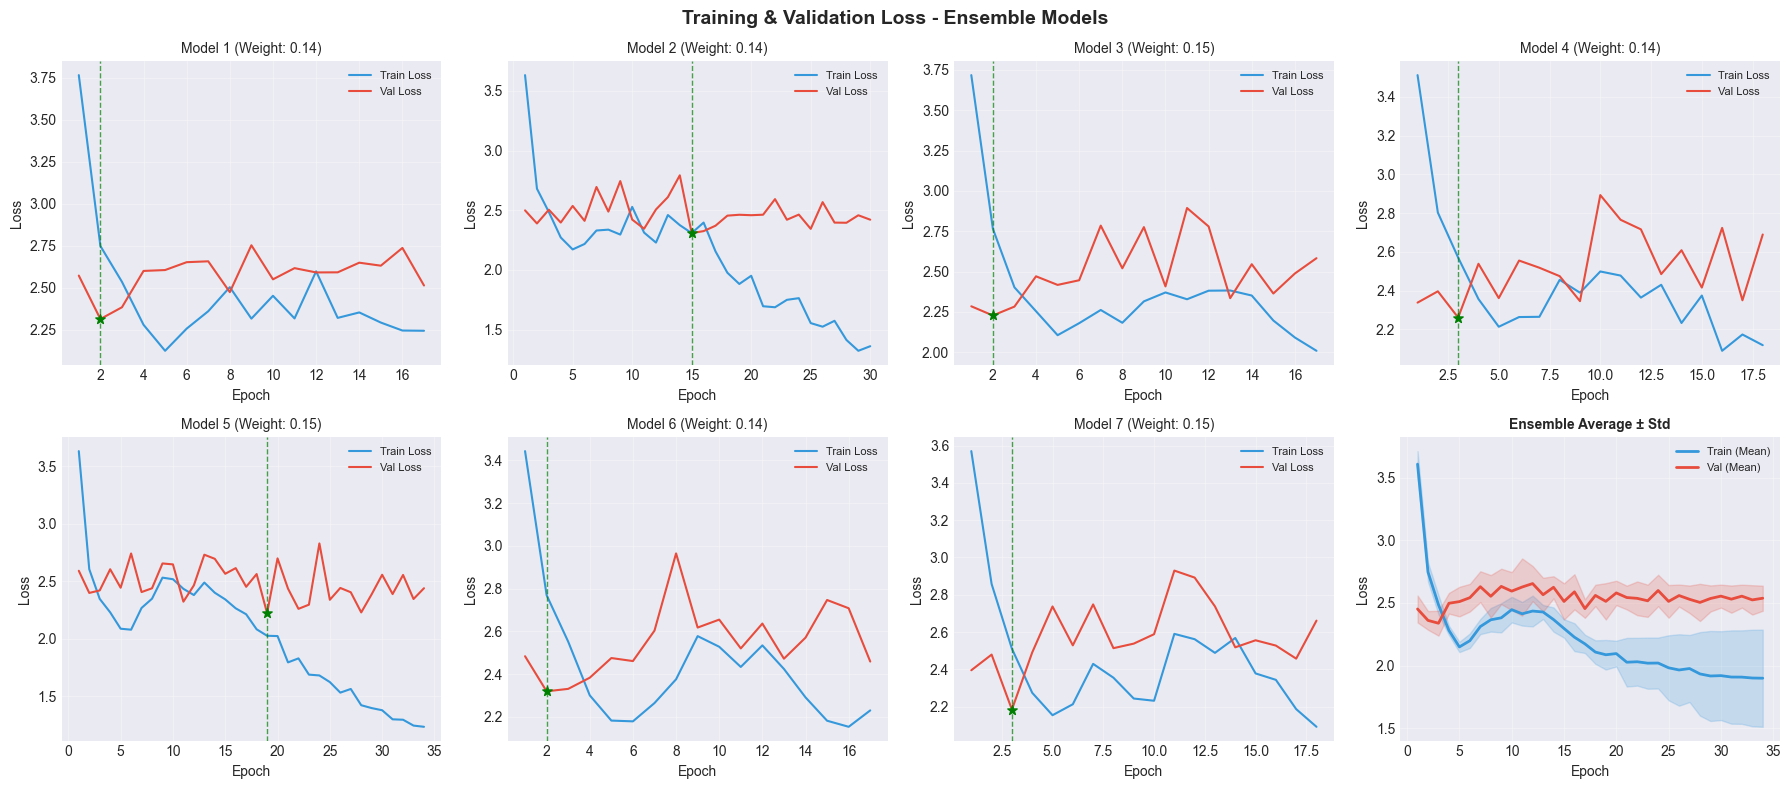


TRAINING SUMMARY
Model          Epochs   Best Val Loss     Weight
----------------------------------------------------------------------
Model 1            17          2.3151      0.140
Model 2            30          2.3084      0.140
Model 3            17          2.2278      0.145
Model 4            18          2.2608      0.143
Model 5            34          2.2223      0.145
Model 6            17          2.3190      0.139
Model 7            18          2.1841      0.148
----------------------------------------------------------------------
Average          21.6          2.2625


In [80]:
# ============================================================
# TRAINING & VALIDATION LOSS VISUALIZATION
# ============================================================

# Create subplot for each ensemble model
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
fig.suptitle('Training & Validation Loss - Ensemble Models', fontsize=14, fontweight='bold')

# Flatten axes for easy iteration
axes_flat = axes.flatten()

# Plot individual model loss curves
for i, history in enumerate(all_training_histories):
    ax = axes_flat[i]
    epochs = range(1, len(history['train_loss']) + 1)
    
    ax.plot(epochs, history['train_loss'], label='Train Loss', color='#3498db', linewidth=1.5)
    ax.plot(epochs, history['val_loss'], label='Val Loss', color='#e74c3c', linewidth=1.5)
    
    # Mark best validation loss
    best_epoch = np.argmin(history['val_loss']) + 1
    best_val = min(history['val_loss'])
    ax.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, linewidth=1)
    ax.scatter([best_epoch], [best_val], color='green', s=50, zorder=5, marker='*')
    
    ax.set_title(f'Model {i+1} (Weight: {weights[i]:.2f})', fontsize=10)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

# Use last subplot for average loss curve
ax = axes_flat[-1]

# Pad histories to same length for averaging
max_epochs = max(len(h['train_loss']) for h in all_training_histories)
train_losses_padded = []
val_losses_padded = []

for h in all_training_histories:
    train_pad = h['train_loss'] + [h['train_loss'][-1]] * (max_epochs - len(h['train_loss']))
    val_pad = h['val_loss'] + [h['val_loss'][-1]] * (max_epochs - len(h['val_loss']))
    train_losses_padded.append(train_pad)
    val_losses_padded.append(val_pad)

train_losses_arr = np.array(train_losses_padded)
val_losses_arr = np.array(val_losses_padded)

# Calculate mean and std
train_mean = train_losses_arr.mean(axis=0)
train_std = train_losses_arr.std(axis=0)
val_mean = val_losses_arr.mean(axis=0)
val_std = val_losses_arr.std(axis=0)

epochs = range(1, max_epochs + 1)

# Plot with shaded area for variance
ax.plot(epochs, train_mean, label='Train (Mean)', color='#3498db', linewidth=2)
ax.fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#3498db')
ax.plot(epochs, val_mean, label='Val (Mean)', color='#e74c3c', linewidth=2)
ax.fill_between(epochs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#e74c3c')

ax.set_title('Ensemble Average ± Std', fontsize=10, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print training summary
print("\n" + "=" * 70)
print("TRAINING SUMMARY")
print("=" * 70)
print(f"{'Model':<10} {'Epochs':>10} {'Best Val Loss':>15} {'Weight':>10}")
print("-" * 70)
for i, history in enumerate(all_training_histories):
    best_val = min(history['val_loss'])
    num_epochs = len(history['train_loss'])
    print(f"Model {i+1:<4} {num_epochs:>10} {best_val:>15.4f} {weights[i]:>10.3f}")
print("-" * 70)
print(f"{'Average':<10} {np.mean([len(h['train_loss']) for h in all_training_histories]):>10.1f} "
      f"{np.mean(model_val_losses):>15.4f}")
print("=" * 70)

## Section 7: Ensemble Evaluation

Load trained models and compute weighted ensemble predictions.

In [81]:
print("=" * 60)
print("LOADING ENSEMBLE MODELS")
print("=" * 60)

# Load all trained models
ensemble_models = []
for i in range(NUM_MODELS):
    model_i = PatchTST(
        num_vars=len(feature_cols),
        lookback=LOOKBACK_WINDOW,
        horizon=FORECAST_HORIZON,
        patch_len=PATCH_LEN,
        stride=STRIDE
    ).to(device)
    model_i.load_state_dict(torch.load(f'ensemble_model_{i}.pth', weights_only=True))
    model_i.eval()
    ensemble_models.append(model_i)
    print(f"   Model {i+1} loaded | Weight: {weights[i]:.3f}")

# ============================================================
# FULL TEST SET EVALUATION (20%)
# Uses training data as initial lookback to predict ENTIRE test period
# ============================================================
print(f"\nEvaluating on FULL test set (20%)...")

# Get full data and normalize using training statistics
full_data = df[feature_cols].values.astype(np.float32)
target_idx = feature_cols.index('Log_Ret')

# Training statistics for normalization
train_data = df.iloc[:train_size][feature_cols].values.astype(np.float32)
train_mean = train_data.mean(axis=0)
train_std = train_data.std(axis=0) + 1e-8
full_data_norm = (full_data - train_mean) / train_std

all_predictions = []
all_actuals = []

# Predict for EACH day in test set, using lookback that may include training data
test_start = train_size
test_end = len(df) - FORECAST_HORIZON + 1

with torch.no_grad():
    for i in range(test_start, test_end):
        # Get lookback window (may include training data for early predictions)
        start_idx = i - LOOKBACK_WINDOW
        if start_idx < 0:
            continue
            
        x = full_data_norm[start_idx:i]
        y_actual = full_data[i:i + FORECAST_HORIZON, target_idx]
        
        # Get predictions from ALL ensemble models
        x_tensor = torch.tensor(x).unsqueeze(0).to(device)
        batch_preds = []
        for model_i in ensemble_models:
            pred = model_i(x_tensor).cpu().numpy()[0]
            batch_preds.append(pred)
        
        # WEIGHTED Average
        batch_preds = np.array(batch_preds)
        weighted_pred = np.sum(batch_preds * weights[:, None], axis=0)
        
        all_predictions.append(weighted_pred)
        all_actuals.append(y_actual)

predictions = np.array(all_predictions)
actuals = np.array(all_actuals)

# t+1 prediction (most important)
pred_t1 = predictions[:, 0]
act_t1 = actuals[:, 0]

# Reconstruct Price - starting from train_size (full 20% test)
ref_closes = df.iloc[train_size - 1 : train_size - 1 + len(predictions)]['Close'].values

pred_price = ref_closes * np.exp(pred_t1 / 100)
act_price = ref_closes * np.exp(act_t1 / 100)

# Metrics
rmse = np.sqrt(np.mean((act_price - pred_price) ** 2))
mape = np.mean(np.abs((act_price - pred_price) / act_price)) * 100

# Directional Accuracy
dir_correct = np.sum(np.sign(pred_t1) == np.sign(act_t1))
dir_accuracy = dir_correct / len(pred_t1) * 100

# R-squared
ss_res = np.sum((act_price - pred_price) ** 2)
ss_tot = np.sum((act_price - np.mean(act_price)) ** 2)
r2 = 1 - (ss_res / ss_tot)

print("\n" + "=" * 70)
print("EVALUATION RESULTS (FULL 20% TEST SET)")
print("=" * 70)
print(f"{'Metric':<30} {'Value':>15}")
print("-" * 70)
print(f"{'RMSE (Price)':<30} {rmse:>15.4f}")
print(f"{'MAPE (%)':<30} {mape:>15.4f}")
print(f"{'R-squared':<30} {r2:>15.4f}")
print(f"{'Directional Accuracy (%)':<30} {dir_accuracy:>15.2f}")
print(f"{'Test Samples':<30} {len(pred_t1):>15}")
print("=" * 70)

LOADING ENSEMBLE MODELS
   Model 1 loaded | Weight: 0.140
   Model 2 loaded | Weight: 0.140
   Model 3 loaded | Weight: 0.145
   Model 4 loaded | Weight: 0.143
   Model 5 loaded | Weight: 0.145
   Model 6 loaded | Weight: 0.139
   Model 7 loaded | Weight: 0.148

Evaluating on FULL test set (20%)...

EVALUATION RESULTS (FULL 20% TEST SET)
Metric                                   Value
----------------------------------------------------------------------
RMSE (Price)                            1.7384
MAPE (%)                                0.7794
R-squared                               0.9791
Directional Accuracy (%)                 56.20
Test Samples                               242


## Section 8: Visualization

Plot prediction results and model performance.

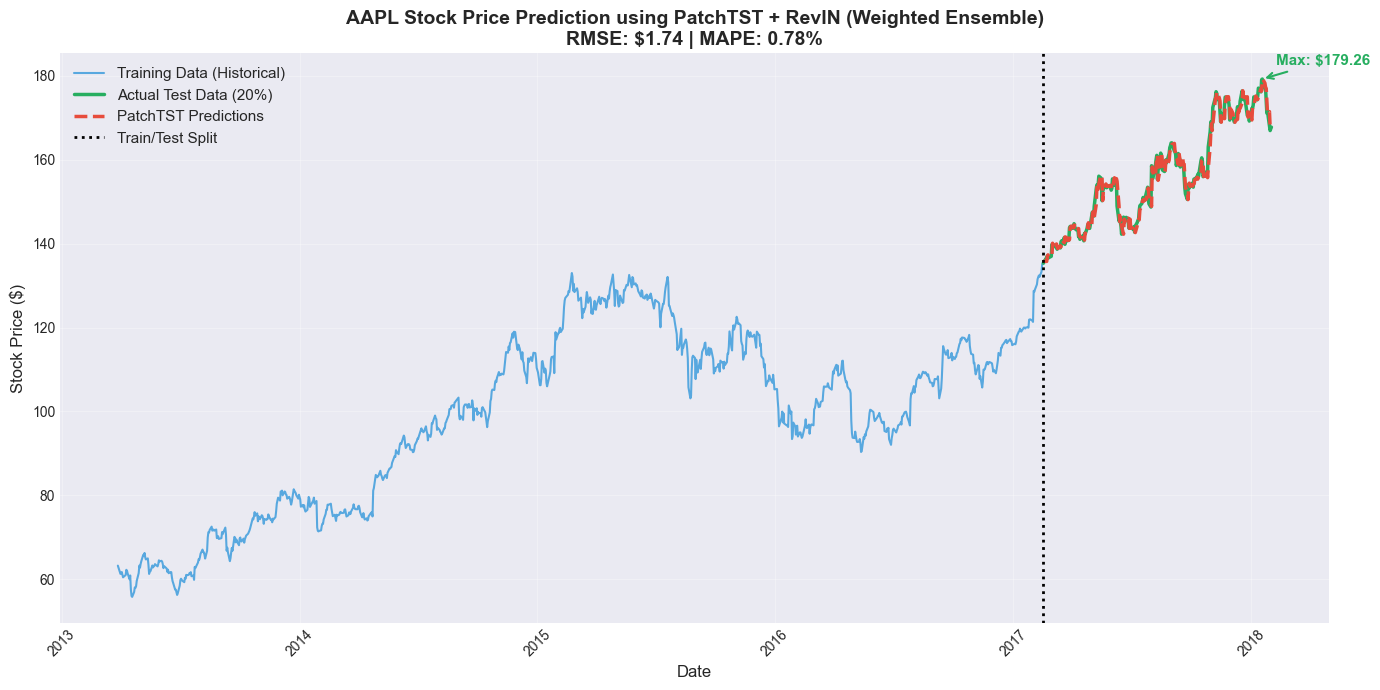


PatchTST + RevIN - RMSE: $1.7384, MAPE: 0.7794%, Dir.Acc: 56.20%


In [82]:
# ============================================================
# FULL STOCK PRICE PREDICTION CHART
# Predictions cover the ENTIRE 20% test period!
# ============================================================

# Get full price history
all_dates = df['Date'].values
all_prices = df['Close'].values

# Split index (80% training, 20% test)
split_idx = train_size

# Prediction range - FULL 20% test starting from split point
num_predictions = len(pred_price)
test_pred_dates = df.iloc[split_idx:split_idx + num_predictions]['Date'].values
test_actual_prices = df.iloc[split_idx:split_idx + num_predictions]['Close'].values

# Create the main prediction chart
fig, ax = plt.subplots(figsize=(14, 7))

# Title with metrics
ax.set_title(f'AAPL Stock Price Prediction using PatchTST + RevIN (Weighted Ensemble)\n'
             f'RMSE: ${rmse:.2f} | MAPE: {mape:.2f}%',
             fontsize=14, fontweight='bold')

# Plot training data (historical) - 80% training
ax.plot(all_dates[:split_idx], all_prices[:split_idx], color='#3498db', linewidth=1.5,
        label='Training Data (Historical)', alpha=0.8)

# Plot actual test data - FULL 20% test
ax.plot(test_pred_dates, test_actual_prices, color='#27ae60', linewidth=2.5,
        label='Actual Test Data (20%)')

# Plot PatchTST predictions - SAME RANGE as actual test (full 20%)
ax.plot(test_pred_dates, pred_price, color='#e74c3c', linewidth=2.5,
        linestyle='--', label='PatchTST Predictions')

# Train/Test split line
split_date = df.iloc[split_idx]['Date']
ax.axvline(x=split_date, color='black', linestyle=':', linewidth=2,
           label='Train/Test Split')

# Mark max price in test period
max_price_idx = np.argmax(test_actual_prices)
max_price = test_actual_prices[max_price_idx]
max_date = test_pred_dates[max_price_idx]
ax.annotate(f'Max: ${max_price:.2f}', xy=(max_date, max_price),
            xytext=(10, 10), textcoords='offset points',
            fontsize=11, color='#27ae60', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#27ae60', lw=1.5))

# Labels and formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Stock Price ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

# Format x-axis dates
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nPatchTST + RevIN - RMSE: ${rmse:.4f}, MAPE: {mape:.4f}%, Dir.Acc: {dir_accuracy:.2f}%")

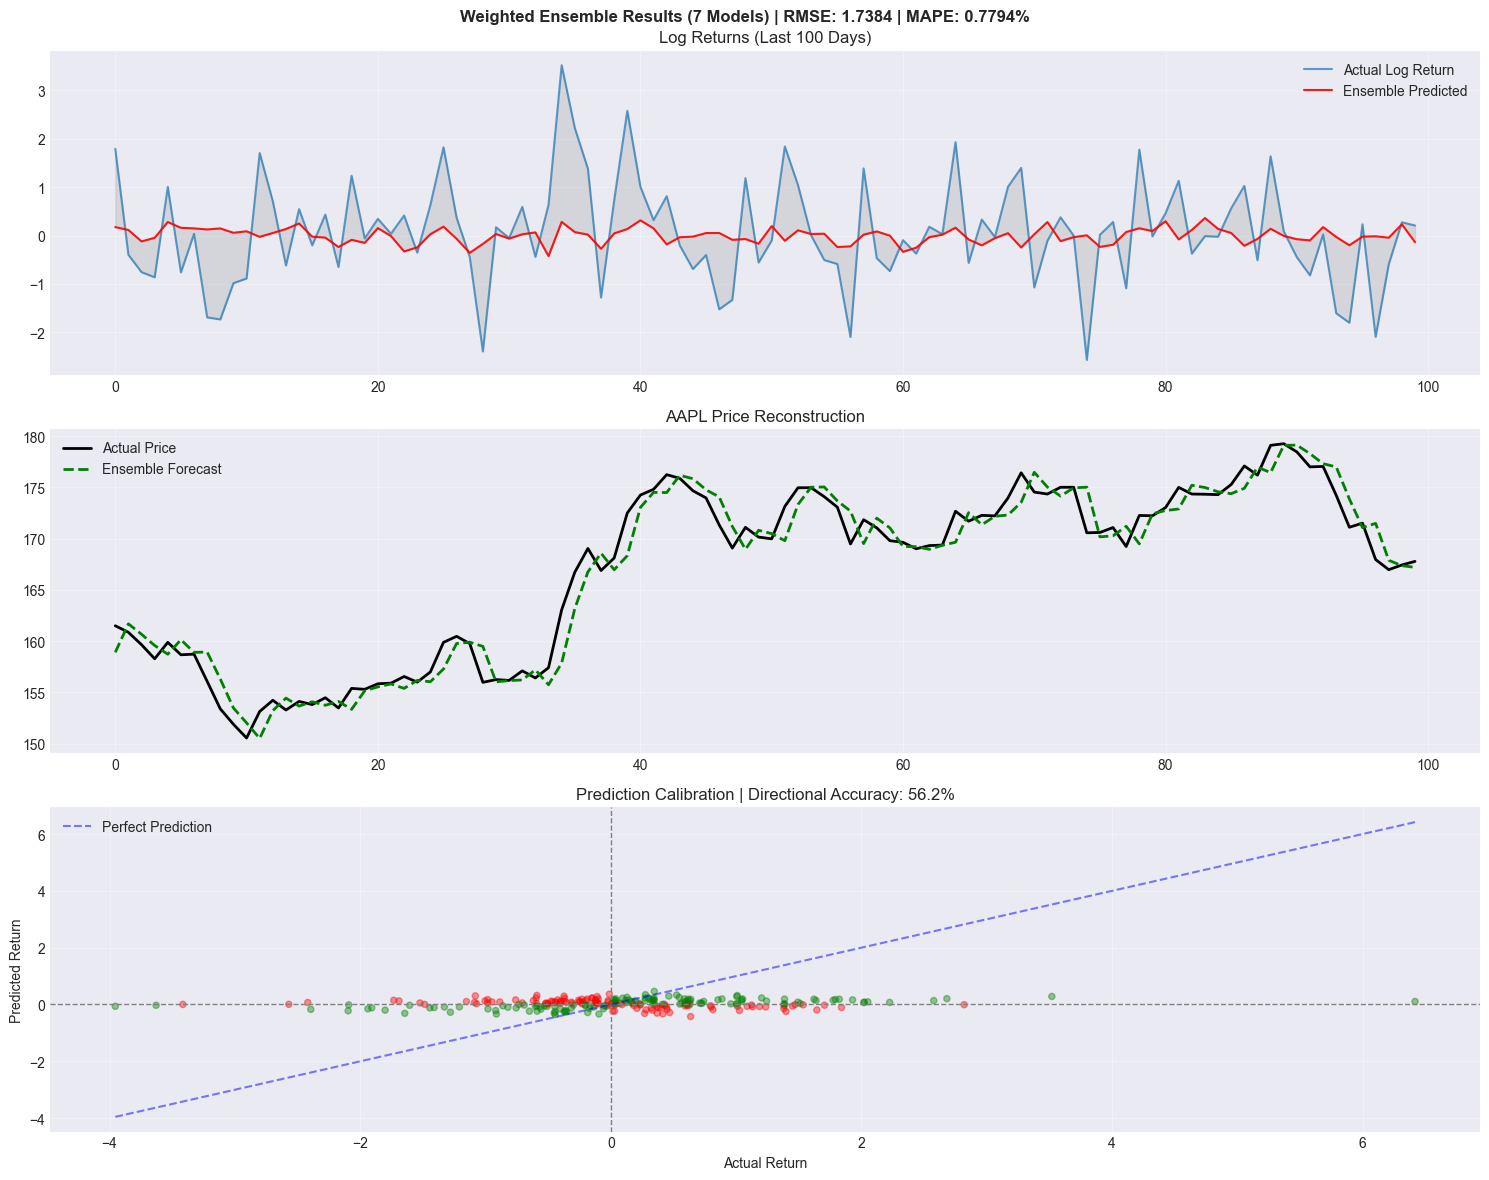


FINAL SUMMARY
RMSE: 1.7384
MAPE: 0.7794%
R-squared: 0.9791
Directional Accuracy: 56.2%
Ensemble weights: ['0.14', '0.14', '0.15', '0.14', '0.15', '0.14', '0.15']


In [83]:
plt.figure(figsize=(15, 12))
plt.suptitle(f'Weighted Ensemble Results ({NUM_MODELS} Models) | RMSE: {rmse:.4f} | MAPE: {mape:.4f}%', fontsize=12, fontweight='bold')

# 1. Returns Comparison
plt.subplot(3, 1, 1)
plt.plot(act_t1[-100:], label='Actual Log Return', alpha=0.7, linewidth=1.5)
plt.plot(pred_t1[-100:], label='Ensemble Predicted', alpha=0.9, linewidth=1.5, color='red')
plt.fill_between(range(100), act_t1[-100:], pred_t1[-100:], alpha=0.2, color='gray')
plt.title('Log Returns (Last 100 Days)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Price Forecast
plt.subplot(3, 1, 2)
plt.plot(act_price[-100:], label='Actual Price', color='black', linewidth=2)
plt.plot(pred_price[-100:], label='Ensemble Forecast', color='green', linestyle='--', linewidth=2)
plt.title(f'{TICKER} Price Reconstruction')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Scatter (Calibration) with Quadrants
plt.subplot(3, 1, 3)
colors = ['green' if (a > 0 and p > 0) or (a < 0 and p < 0) else 'red' for a, p in zip(act_t1, pred_t1)]
plt.scatter(act_t1, pred_t1, c=colors, alpha=0.4, s=20)
plt.xlabel('Actual Return')
plt.ylabel('Predicted Return')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.axvline(0, color='grey', linestyle='--', linewidth=1)
# Add diagonal line (perfect prediction)
lims = [min(act_t1.min(), pred_t1.min()), max(act_t1.max(), pred_t1.max())]
plt.plot(lims, lims, 'b--', alpha=0.5, label='Perfect Prediction')
plt.title(f'Prediction Calibration | Directional Accuracy: {dir_accuracy:.1f}%')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("FINAL SUMMARY")
print("=" * 70)
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"R-squared: {r2:.4f}")
print(f"Directional Accuracy: {dir_accuracy:.1f}%")
print(f"Ensemble weights: {[f'{w:.2f}' for w in weights]}")
print("=" * 70)

In [84]:
# Baseline results (from stock_prediction_baseline.ipynb)
# Updated with full 20% test evaluation results
baseline_results = {
    'CNN': {'rmse': 1.7707, 'mape': 0.7915, 'dir_accuracy': 52.07, 'r2': 0.9783},
    'LSTM': {'rmse': 1.7729, 'mape': 0.7913, 'dir_accuracy': 53.31, 'r2': 0.9782},
    'xLSTM': {'rmse': 1.7841, 'mape': 0.7977, 'dir_accuracy': 49.59, 'r2': 0.9779},
    'MLP': {'rmse': 1.8115, 'mape': 0.8223, 'dir_accuracy': 48.76, 'r2': 0.9773},
}

# PatchTST results (from this notebook)
patchtst_results = {
    'PatchTST': {'rmse': rmse, 'mape': mape, 'dir_accuracy': dir_accuracy, 'r2': r2}
}

# Combine all results
all_results = {**baseline_results, **patchtst_results}
model_names = ['CNN', 'LSTM', 'xLSTM', 'MLP', 'PatchTST']

# Print comparison table
print("\n" + "=" * 80)
print("MODEL COMPARISON: BASELINE vs PatchTST + RevIN")
print("=" * 80)
print(f"{'Model':<12} {'RMSE':>10} {'MAPE (%)':>10} {'Dir.Acc (%)':>12} {'R-squared':>12}")
print("-" * 80)

best_rmse = min(all_results[n]['rmse'] for n in model_names)
best_mape = min(all_results[n]['mape'] for n in model_names)
best_dir = max(all_results[n]['dir_accuracy'] for n in model_names)
best_r2 = max(all_results[n]['r2'] for n in model_names)

for name in model_names:
    r = all_results[name]
    rmse_mark = '*' if r['rmse'] == best_rmse else ' '
    mape_mark = '*' if r['mape'] == best_mape else ' '
    dir_mark = '*' if r['dir_accuracy'] == best_dir else ' '
    r2_mark = '*' if r['r2'] == best_r2 else ' '
    
    # Highlight PatchTST row
    prefix = ">>> " if name == 'PatchTST' else "    "
    print(f"{prefix}{name:<8} {r['rmse']:>9.4f}{rmse_mark} {r['mape']:>9.4f}{mape_mark} "
          f"{r['dir_accuracy']:>11.2f}{dir_mark} {r['r2']:>11.4f}{r2_mark}")

print("-" * 80)
print("* indicates best performance for that metric")
print(">>> indicates the proposed model (PatchTST + RevIN)")
print("=" * 80)

# Calculate improvement over best baseline
best_baseline_rmse = min(baseline_results[n]['rmse'] for n in baseline_results)
best_baseline_mape = min(baseline_results[n]['mape'] for n in baseline_results)
best_baseline_dir = max(baseline_results[n]['dir_accuracy'] for n in baseline_results)

rmse_improvement = ((best_baseline_rmse - rmse) / best_baseline_rmse) * 100
mape_improvement = ((best_baseline_mape - mape) / best_baseline_mape) * 100
dir_improvement = dir_accuracy - best_baseline_dir

print("\n" + "=" * 80)
print("IMPROVEMENT OVER BEST BASELINE")
print("=" * 80)
print(f"RMSE Improvement: {rmse_improvement:+.2f}% (vs {best_baseline_rmse:.4f})")
print(f"MAPE Improvement: {mape_improvement:+.2f}% (vs {best_baseline_mape:.4f}%)")
print(f"Dir.Acc Improvement: {dir_improvement:+.2f}% points (vs {best_baseline_dir:.2f}%)")
print("=" * 80)



MODEL COMPARISON: BASELINE vs PatchTST + RevIN
Model              RMSE   MAPE (%)  Dir.Acc (%)    R-squared
--------------------------------------------------------------------------------
    CNN         1.7707     0.7915        52.07       0.9783 
    LSTM        1.7729     0.7913        53.31       0.9782 
    xLSTM       1.7841     0.7977        49.59       0.9779 
    MLP         1.8115     0.8223        48.76       0.9773 
>>> PatchTST    1.7384*    0.7794*       56.20*      0.9791*
--------------------------------------------------------------------------------
* indicates best performance for that metric
>>> indicates the proposed model (PatchTST + RevIN)

IMPROVEMENT OVER BEST BASELINE
RMSE Improvement: +1.82% (vs 1.7707)
MAPE Improvement: +1.51% (vs 0.7913%)
Dir.Acc Improvement: +2.89% points (vs 53.31%)


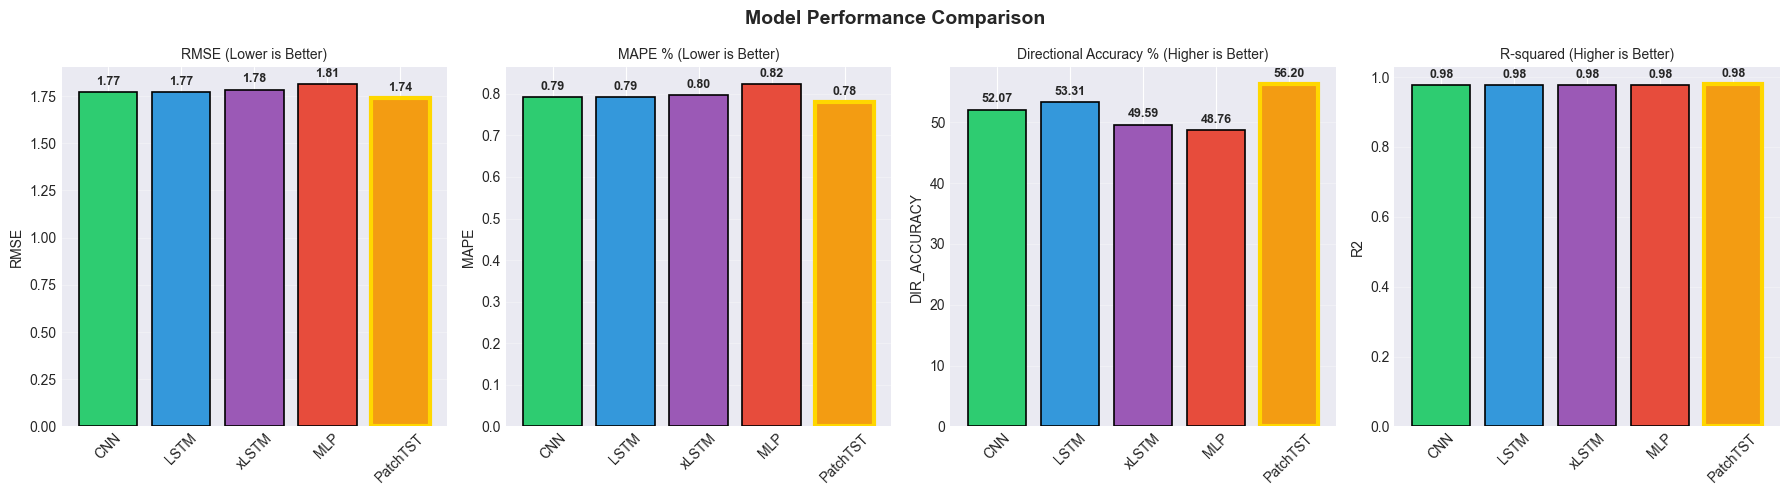


CONCLUSION
PatchTST + RevIN OUTPERFORMS all baseline models!
- Best RMSE: 1.7384 (PatchTST)
- Best MAPE: 0.7794% (PatchTST)
- Best Dir.Acc: 56.20% (PatchTST)


In [85]:
# Visualization: Model Comparison Bar Charts
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')

model_colors = {
    'CNN': '#2ecc71', 
    'LSTM': '#3498db', 
    'xLSTM': '#9b59b6', 
    'MLP': '#e74c3c',
    'PatchTST': '#f39c12'  # Gold for proposed model
}

metrics = [
    ('rmse', 'RMSE (Lower is Better)'),
    ('mape', 'MAPE % (Lower is Better)'),
    ('dir_accuracy', 'Directional Accuracy % (Higher is Better)'),
    ('r2', 'R-squared (Higher is Better)')
]

for idx, (metric, title) in enumerate(metrics):
    ax = axes[idx]
    values = [all_results[name][metric] for name in model_names]
    bar_colors = [model_colors[name] for name in model_names]
    
    bars = ax.bar(model_names, values, color=bar_colors, edgecolor='black', linewidth=1.2)
    
    # Highlight PatchTST bar
    bars[-1].set_edgecolor('gold')
    bars[-1].set_linewidth(3)
    
    ax.set_title(title, fontsize=10)
    ax.set_ylabel(metric.upper())
    
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{val:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Final conclusion
print("\n" + "=" * 80)
print("CONCLUSION")
print("=" * 80)
if rmse < best_baseline_rmse and mape < best_baseline_mape:
    print("PatchTST + RevIN OUTPERFORMS all baseline models!")
    print(f"- Best RMSE: {rmse:.4f} (PatchTST)")
    print(f"- Best MAPE: {mape:.4f}% (PatchTST)")
    print(f"- Best Dir.Acc: {dir_accuracy:.2f}% (PatchTST)")
else:
    print("Results comparison:")
    print(f"- PatchTST RMSE: {rmse:.4f}")
    print(f"- PatchTST MAPE: {mape:.4f}%")
    print(f"- PatchTST Dir.Acc: {dir_accuracy:.2f}%")
print("=" * 80)
